# Hands-On NLP
## Project : Text Generation and Chatbot for Song Lyrics

<span style="color:magenta">Group Names:</span>

* Petko Petkov
* Manda ANDRIAMAROMANANA
* Ilyes SAIS

Install required libraries:

In [13]:
!pip install torch datasets pandas tqdm transformers trl matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 3.4 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.9 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pyparsing-3.2.1-

Import required libraries:

In [14]:
import torch
from datasets import load_dataset
import pandas as pd
import os
import json
from tqdm import tqdm
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, DataCollatorForSeq2Seq, pipeline
from trl import SFTTrainer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Set Hugging Face token as environment variable:

In [4]:
os.environ["HF_TOKEN"] = "YOUR_TOKEN"

**1. Generate descriptions  (or the complete instructions that we're going to use for the training of our model) for the song lyrics in the dataset, we should use another more capable model like ChatGPT, Claude, Gemini, etc.** 

In [ ]:
INPUT_DATASET_REPO = "vishnupriyavr/spotify-million-song-dataset"
OUTPUT_DATASET_REPO = "petkopetkov/spotify-million-song-dataset-descriptions"
HF_DATASET_SPLIT = "train"
CHECKPOINT_FILE = "songs_descriptions_checkpoint.json"

dataset = load_dataset(INPUT_DATASET_REPO, split=HF_DATASET_SPLIT)

if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE, "r") as f:
        checkpoint_data = json.load(f)
else:
    checkpoint_data = {}

completed_indices = set(checkpoint_data.keys())

pipe = pipeline(
    "text-generation",
    model="google/gemma-2-2b-it",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

def generate_description(artist, song, lyrics):
    prompt = f"""Describe the following song based on the lyrics in a **comma-separated list** of adjectives and stylistic traits (can be more complex expressions or just simple words that a person would use to describe the song). 
    The description should include **mood, atmosphere, style, lyrical structure, and the artist's name**.
    
    Artist: {artist}
    Song: {song}
    Lyrics: {lyrics[:2000]}
    
    Description:"""

    try:
        messages = [
            {"role": "user", "content": prompt}
        ]

        outputs = pipe(messages, max_new_tokens=100, batch_size=32)
        
        return outputs[0]["generated_text"][-1]["content"].strip()
    except Exception as e:
        print(f"Error generating description: {e}")
        return None

requests_made = 0
start_time = time.time()

if "description" not in dataset.column_names:
    dataset = dataset.add_column("description", [""] * len(dataset))
    
new_descriptions = dataset["description"]

for i, desc in checkpoint_data.items():
    new_descriptions[int(i)] = desc

for i in tqdm(range(len(dataset)), desc="Generating descriptions"):
    if str(i) in completed_indices:
        continue

    artist = dataset[i]["artist"]
    song = dataset[i]["song"]
    lyrics = dataset[i]["text"]

    description = generate_description(artist, song, lyrics)
    
    if description:
        new_descriptions[i] = description
        checkpoint_data[str(i)] = description
        completed_indices.add(str(i))

    if i % 10 == 0:
        with open(CHECKPOINT_FILE, "w") as f:
            json.dump(checkpoint_data, f)
            
dataset = dataset.remove_columns("description")
dataset = dataset.add_column("description", new_descriptions)

dataset.push_to_hub(OUTPUT_DATASET_REPO)

print("Dataset successfully updated and pushed to Hugging Face!")


# Dataset exploration

In [20]:
DATASET_NAME = "petkopetkov/spotify-million-song-dataset-descriptions"

dataset = load_dataset(DATASET_NAME, split="train")

dataset = pd.DataFrame(dataset)

In [21]:
pd.DataFrame(dataset)

,artist,song,link,text,description
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA...","romantic, nostalgic, upbeat, sentimental, warm..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen...","romantic, gentle, soothing, tender, intimate, ..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...,"upbeat, optimistic, reflective, romantic, live..."
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...,"upbeat, joyful, playful, optimistic, catchy, r..."
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...,"uplifting, cheerful, energetic, catchy, playfu..."
...,...,...,...,...,...
57645,Ziggy Marley,Good Old Days,/z/ziggy+marley/good+old+days_10198588.html,Irie days come on play \r\nLet the angels fly...,"Uplifting, hopeful, nostalgic, spiritual, regg..."
57646,Ziggy Marley,Hand To Mouth,/z/ziggy+marley/hand+to+mouth_20531167.html,Power to the workers \r\nMore power \r\nPowe...,"protestant, angry, socially conscious, rhyt..."
57647,Zwan,Come With Me,/z/zwan/come+with+me_20148981.html,all you need \r\nis something i'll believe \...,"Dreamy, yearning, desperate, hopeful, romantic..."
57648,Zwan,Desire,/z/zwan/desire_20148986.html,northern star \r\nam i frightened \r\nwhere ...,"Melancholic, introspective, ethereal, atmosphe..."


# Finetuning models on the dataset

In [ ]:
MODEL_NAMES = ["Qwen/Qwen2.5-0.5B", "HuggingFaceTB/SmolLM2-135M", "HuggingFaceTB/SmolLM2-135M-Instruct", "HuggingFaceTB/SmolLM2-360M", "HuggingFaceTB/SmolLM2-360M-Instruct"]

split_dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_data = split_dataset["train"]
val_data = split_dataset["test"]

# Define tokenizer function
def tokenize_function(examples):
    input_texts = [
        f"Generate song lyrics based on the description: {desc}\nSong lyrics: {text}"
        for desc, text in zip(examples["description"], examples["text"])
    ]

    tokenized_inputs = tokenizer(
        input_texts,
        padding="max_length",
        truncation=True,
        max_length=256
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

use_bf16 = torch.cuda.is_bf16_supported()

for model_name in MODEL_NAMES:
    print(f"=== Training model: {model_name} ===")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    tokenized_train = train_data.map(
        tokenize_function,
        batched=True,
        remove_columns=["description", "text"]
    )
    tokenized_val = val_data.map(
        tokenize_function,
        batched=True,
        remove_columns=["description", "text"]
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
    )
    
    new_model_name = f"{model_name.replace('/', '_')}-song-lyrics-generation"

    training_args = TrainingArguments(
        output_dir=new_model_name,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=8,
        learning_rate=5e-4,
        num_train_epochs=3,
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        push_to_hub=True,
        fp16=not use_bf16,
        bf16=use_bf16,
        report_to="wandb",
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        seed=3407,
        warmup_steps=30,
        eval_strategy="steps",
        logging_dir='./logs',
        eval_steps=100,
        do_eval=True,
        weight_decay=0.1,
        save_steps=200,
        hub_model_id=new_model_name,
    )

    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        padding=True
    )

    trainer = SFTTrainer(
        model=model,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        args=training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.push_to_hub()

# Training results

In [17]:
def plot_losses(model_name):
    img_paths = [f"plots/{model_name}/train_loss.png", f"plots/{model_name}/val_loss.png"]

    img1 = mpimg.imread(img_paths[0])
    img2 = mpimg.imread(img_paths[1])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title(model_name)

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title(model_name)

    plt.tight_layout()
    plt.show()

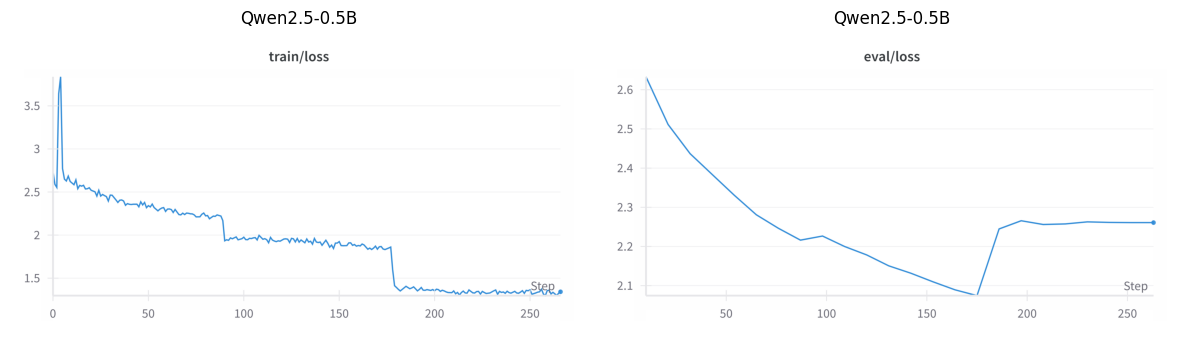

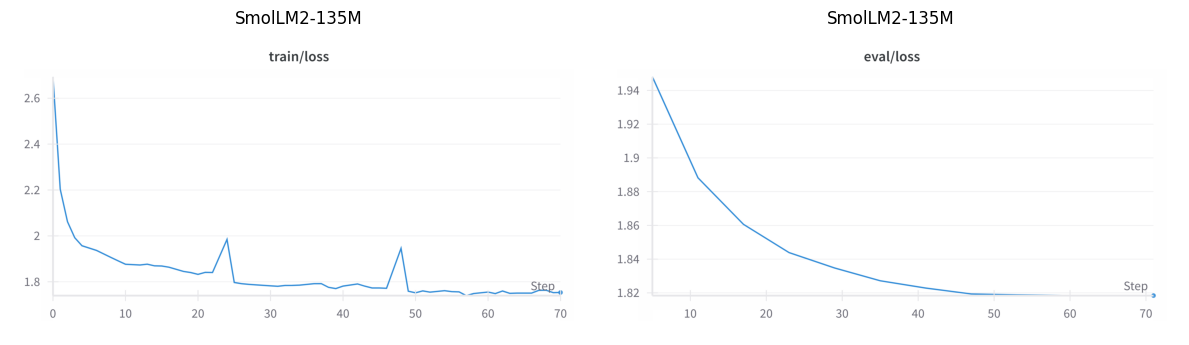

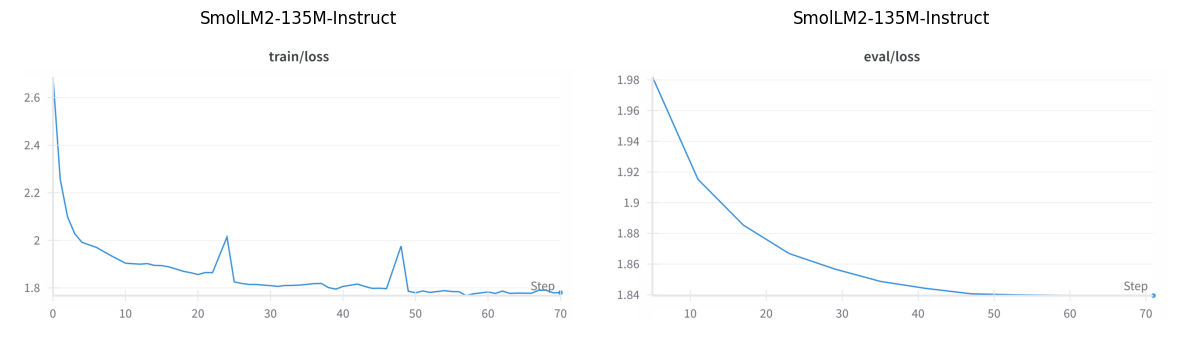

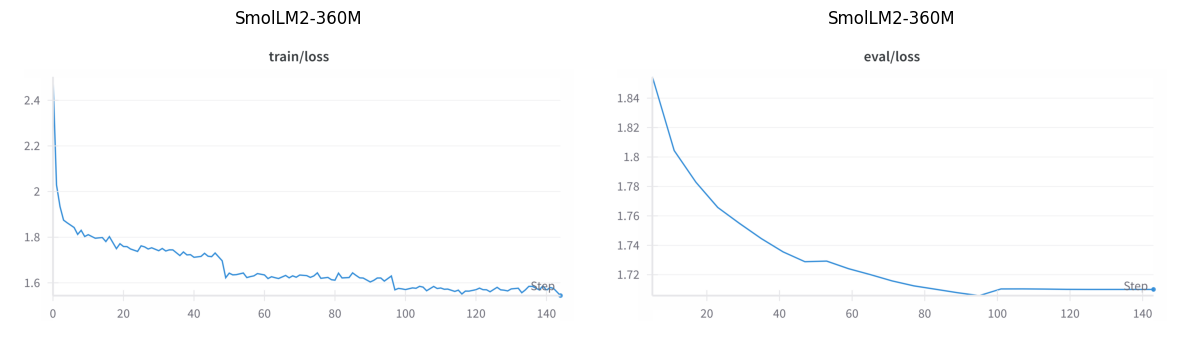

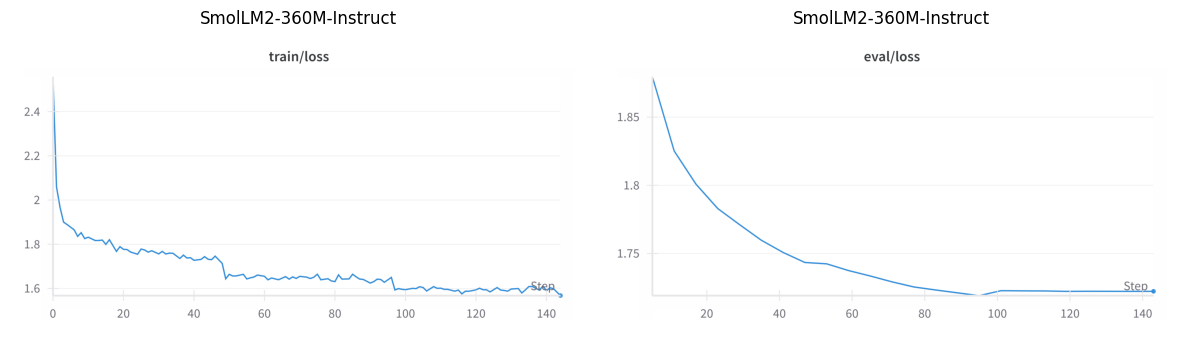

In [19]:
model_names = ["Qwen2.5-0.5B", "SmolLM2-135M", "SmolLM2-135M-Instruct", "SmolLM2-360M", "SmolLM2-360M-Instruct"]

for model_name in model_names:
    plot_losses(model_name)

# Trained models comparison

In [8]:
def compare(model_list, prompt):
    for model_name in model_list:
        generator = pipeline(
            "text-generation",
            model=model_name,
            tokenizer=model_name,
            torch_dtype=torch.bfloat16, 
            device_map="auto",
            max_new_tokens=1024,
            repetition_penalty=1.5,
            # temperature=0.6,
            # do_sample=True
        )

        output = generator(
            prompt,
            # do_sample=True,
            # top_k=50,
            # top_p=0.95
        )
        
        # Print the model name and the generated text
        print(f"\nModel: {model_name}\n")
        print(f"Output: {output[0]['generated_text']}\n")

In [9]:
trained_models_list = [
    'petkopetkov/Qwen2.5-0.5B-song-lyrics-generation',
    'petkopetkov/SmolLM2-135M-song-lyrics-generation',
    'petkopetkov/SmolLM2-135M-Instruct-song-lyrics-generation',
    'petkopetkov/SmolLM2-360M-song-lyrics-generation',
    'petkopetkov/SmolLM2-360M-Instruct-song-lyrics-generation'
]

prompt = "Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe\nSong lyrics:"

compare(trained_models_list, prompt)

Device set to use cuda:0



Model: petkopetkov/Qwen2.5-0.5B-song-lyrics-generation

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: I'm so glad that you're mine  
I can't believe it's true  
You've changed my life completely  
And by telling me lies like this is no lie.  
There are songs in your eyes saying "let go" (Let go)  
But they don't touch nor do for sure  
So let them all fall out of reach  
'Cause we'll be singing happily ever after!  
Happy to say... That there ain't nothing better than knowing exactly what
you mean when you get down inside.  
(Chorus:)  
It makes us feel good because our hearts have never been broken before.
We will sing happily ever after forever more.  
Now every day seems brighter now since yesterday night has come alive at last,
we celebrate today as if having always known tomorrow would bring something but fear into
day. So just hang up or throw away hope - cause happiness comes from finding love

Device set to use cuda:0



Model: petkopetkov/SmolLM2-135M-song-lyrics-generation

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: I'm feeling so good  





Device set to use cuda:0



Model: petkopetkov/SmolLM2-135M-Instruct-song-lyrics-generation

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: I'm feeling so good  

1. "I've got my own little world" (featuring Chris Brown)  
2."It's alright to be free!"(with guitar solo by Chris Brown )





Device set to use cuda:0



Model: petkopetkov/SmolLM2-360M-song-lyrics-generation

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: I'm so glad that you're here  
I can't believe it's true. It feels like heaven to be alive today! (yeah) You make me feel good inside when we are together...and then there is nothing else in this world for us but each other..(oh yeah!) We have everything going our way now baby....we got love all around.....everywhere everywhere everyday of my life i am free from worry or fear at anytime anywhere no matter where u go what ever happens just call up your friends let them know how much they mean too mama ohh yea!!!!! hahaahaaaayyyy!!!!ooooooo owwwwwwow woopeee eewweeetttt yeyuuuuhhhheehe heiieeh hmmmhmme mmmyouyouaresohappythatusboutherexpectingtoseeeachotherallthetimebutnowitisnotlikebeforecause ur not alone anymoreur home againafteryearsofapartnessitsjustonemorethingforus thanever beforewhenverumanythi

Device set to use cuda:0



Model: petkopetkov/SmolLM2-360M-Instruct-song-lyrics-generation

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: I'm feeling so good  
I can't believe it's true.  
10 days of sunshine in my life is making me feel like this! (yeah) yeah...  
It feels amazing to be alive today..(ohh...) It makes you want more than anything else!!!





# Original models comparison

In [11]:
original_models_list = [
    'Qwen/Qwen2.5-0.5B',
    'HuggingFaceTB/SmolLM2-135M',
    'HuggingFaceTB/SmolLM2-135M-Instruct',
    'HuggingFaceTB/SmolLM2-360M',
    'HuggingFaceTB/SmolLM2-360M-Instruct'
]

prompt = "Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe\nSong lyrics:"

compare(original_models_list, prompt)

Device set to use cuda:0



Model: Qwen/Qwen2.5-0.5B

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: "Happy Days" by The Beatles

Verse 1:
In those days when we were young,
We had dreams that would never die.
With love in our hearts like fire so bright.

Chorus (in English):
Oh! Happy times are here again!
Let's dance to this beat of ours!

(Repeat)

Bridge/Outro:

So let us sing along together now...
And make every day count for joy.



Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Model: HuggingFaceTB/SmolLM2-135M

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: "I'm so glad I got this job" (from The Beatles)

1. Happy! - 20 songs by The Beatle that are about happiness or joy in general; most of them have an optimistic tone to their music as well... but some may be more pessimistic than others depending upon how you interpret it :)


35 Songs About Happiness & Joy In General



Device set to use cuda:0



Model: HuggingFaceTB/SmolLM2-135M-Instruct

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: "I love to play" (with an emphasis) 10 times. 
   - I'm in my favorite mood right now!
   - It's so much fun playing music together as friends or family... it makes me feel like we're all just joking around at this moment
    - We can't wait for our next gig/game night!!
  • The best part is that you get more of what your singing about than most songs do – lots o' good stuff going down there…and some great tunes too!!!



Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Model: HuggingFaceTB/SmolLM2-360M

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: "I'm so glad I found you" by The Beatles (1968)

2. **Create an original melody for your chosen tune:** Using free online tools like Melody Maker or GarageBand from Apple Music allows users to generate melodies directly within their devices without needing any external software installed first! Simply input keywords associated along side each lyric line until satisfied enough; then export as MP3 files ready instantly upon download/playback later in life mode settings preferences under 'Music' tab inside iTunes library management system too



Device set to use cuda:0



Model: HuggingFaceTB/SmolLM2-360M-Instruct

Output: Generate song lyrics based on the description: happy, joyful, and carefree, with a positive and uplifting vibe
Song lyrics: "I'm so glad to be alive" (for someone who is celebrating their birthday) or 1984 by The Cure ("You're my rock") for an individual experiencing loss.

